In [0]:
! git clone https://github.com/Xiar-fatah/Cat_vs_Dog.git


Cloning into 'Cat_vs_Dog'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 37467 (delta 29), reused 59 (delta 21), pack-reused 37399
Receiving objects: 100% (37467/37467), 828.54 MiB | 45.11 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Checking out files: 100% (37509/37509), done.


Epoch [1/5], Step [100/782], Loss: 0.6254, Accuracy: 65.62%
Epoch [1/5], Step [200/782], Loss: 0.5496, Accuracy: 75.00%
Epoch [1/5], Step [300/782], Loss: 0.5086, Accuracy: 78.12%
Epoch [1/5], Step [400/782], Loss: 0.5460, Accuracy: 65.62%
Epoch [1/5], Step [500/782], Loss: 0.4533, Accuracy: 84.38%
Epoch [1/5], Step [600/782], Loss: 0.4142, Accuracy: 78.12%
Epoch [1/5], Step [700/782], Loss: 0.4778, Accuracy: 71.88%
Epoch [2/5], Step [100/782], Loss: 0.6685, Accuracy: 65.62%
Epoch [2/5], Step [200/782], Loss: 0.3880, Accuracy: 84.38%
Epoch [2/5], Step [300/782], Loss: 0.4607, Accuracy: 75.00%
Epoch [2/5], Step [400/782], Loss: 0.4731, Accuracy: 78.12%
Epoch [2/5], Step [500/782], Loss: 0.5606, Accuracy: 68.75%
Epoch [2/5], Step [600/782], Loss: 0.4934, Accuracy: 78.12%
Epoch [2/5], Step [700/782], Loss: 0.4048, Accuracy: 75.00%
Epoch [3/5], Step [100/782], Loss: 0.6002, Accuracy: 68.75%
Epoch [3/5], Step [200/782], Loss: 0.4625, Accuracy: 71.88%
Epoch [3/5], Step [300/782], Loss: 0.660

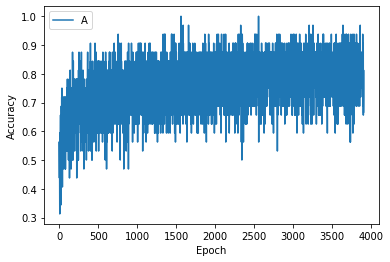

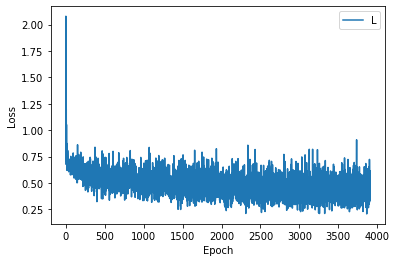

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
CUDA_LAUNCH_BLOCKING=1

####################### CNN #######################
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =  64, kernel_size=5, stride=1, padding=0), #Try new kernel_sizes and write down the whole forward proga
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        
        self.fc1 = nn.Linear(238144, 32)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, t):
        t.cuda(device)
#        print("Before sending to first conv2d layer")
#        print(t.shape)
        t = self.layer1(t)
#        print("First conv2d layer")
#        print(t.shape)
        t = self.layer2(t)
#        print("Second conv2d layer")
#        print(t.shape)
        t = t.reshape(t.size(0), -1)
#        print("Reshape")
#        print(t.shape)
        t = self.drop_out(t)
        #print("Drop_out")
        #print(t.shape)
        t = self.fc1(t)
#        print("fc1")
#        print(t.shape)
        t = self.fc2(t)
#        print("fc2")
#        print(t.shape)
        #print(t)
        return t



if __name__ == "__main__":
    ####################### Prepossessing Data #######################
    train_dir = '/content/Cat_vs_Dog/Data/dataset' 
    test_dir = '/content/Cat_vs_Dog/Data/testset' 
    mean = [0.485, 0.456, 0.406] 
    std  = [0.229, 0.224, 0.225]
    transforms= transforms.Compose([
            transforms.Resize((256,256)),
            transforms.RandomRotation(30),
            #transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
    #        transforms.Grayscale(3),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
    
    train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

    trainloader = torch.utils.data.DataLoader(train_dataset , batch_size=64, #try new batch_sizes
                                              shuffle=True, num_workers=4)
    test_dataset = datasets.ImageFolder(test_dir, transform=transforms)
    
    testloader = torch.utils.data.DataLoader(train_dataset , batch_size=64,
                                              shuffle=False, num_workers=4)
    model = CNN()
    model.cuda(device)
    learning_rate = 0.0001 #change this value 
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(trainloader)
    num_epochs = 5
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)  # missing line from original code
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
    
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
    
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
                
    images = np.linspace(0,len(loss_list)-1,len(loss_list))
    plt.figure()  
    plt.plot(images, acc_list)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(("Accuracy"))
    plt.figure()
    plt.plot(images, loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(("Loss"))
    
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
#












